Matlab code from Romain

```matlab
close all;clear all;clc;
function Bvec = Brond(x,y,z)
  r = sqrt(x.^2+y.^2+z.^2);
  Bxx = 0.5*log((r-z)./(r+z));
  Byy = -atan(y.*r./(x.*z));
  Bzz = 0.5*log((r-x)./(r+x));
  len = prod(size(r));
  Bvec = reshape([reshape(Bxx,[len,1]),reshape(Byy,[len,1]),reshape(Bzz,[len,1])],[size(r),3]);
end
function Bvec = Bmagnet(x,y,z,a,b,c,Br)
  Bvec = Br/(4*pi)*(Brond(x-a,y-b,z-c)-Brond(x+a,y-b,z-c)+...
                  Brond(x+a,y+b,z-c)-Brond(x-a,y+b,z-c)+...
                  Brond(x-a,y+b,z+c)-Brond(x-a,y-b,z+c)+...
                  Brond(x+a,y-b,z+c)-Brond(x+a,y+b,z+c));
end
function Bvec = Bdisrot(x,y,z,a,b,c,Br,r0,z0,alpha,beta)
  %% Translation
  xp = x-r0*sin(beta);
  yp = y-r0*cos(beta);
  zp = z-z0;
  %% First rotation 2*beta around z
  xs = cos(2*beta)*xp-sin(2*beta)*yp;
  ys = sin(2*beta)*xp+cos(2*beta)*yp;
  zs = zp;
  %% Second rotation alpha around v = cos(beta) exs + sin(beta) eys
  cb = cos(beta);ca = cos(alpha);sb = sin(beta);sa = sin(alpha);
  xt = (cb^2*(1-ca)+ca)*xs + cb*sb*(1-ca)*ys + sb*sa*zs;
  yt = cb*sb*(1-ca)*xs + (sb^2*(1-ca)+ca)*ys - cb*sa*zs;
  zt = -sb*sa*xs + cb*sa*ys + ca*zs;
  %%
  Bvec = Bmagnet(xt,yt,zt,a,b,c,Br);
  dim = size(Bvec);
  len = prod(dim(1:end-1));
  Bvec = reshape(Bvec,len,3);
  Bxt = Bvec(:,1);
  Byt = Bvec(:,2);
  Bzt = Bvec(:,3);
  %% Undo rotations
  Bxs = (cb^2*(1-ca)+ca)*Bxt + cb*sb*(1-ca)*Byt - sb*sa*Bzt;
  Bys = cb*sb*(1-ca)*Bxt + (sb^2*(1-ca)+ca)*Byt + cb*sa*Bzt;
  Bzs = sb*sa*Bxt - cb*sa*Byt + ca*Bzt;
  %%
  Bx = cos(2*beta)*Bxs+sin(2*beta)*Bys;
  By = -sin(2*beta)*Bxs+cos(2*beta)*Bys;
  Bz = Bzs;
  %%
  Bvec = reshape([Bx,By,Bz],dim);
end
function Bvec = BHallbach8(x,y,z,a,b,c,Br,R0,z0,alpha)
  Bvec = 0;
  for beta=[0,pi/4,pi/2,3*pi/4,pi,5*pi/4,3*pi/2,7*pi/4]
    Btmp = Bdisrot(x,y,z,a,b,c,Br,R0,z0,alpha,beta);
    Bvec = Bvec + Btmp;
  end
end
function res = By(x,y,z,a,b,c,Br,R0,z0,alpha)
  Bvec = BHallbach8(x,y,z,a,b,c,Br,R0,z0,alpha);
  dim = size(Bvec);
  len = prod(dim(1:end-1));
  Bvec = reshape(Bvec,[len,3]);
  res = reshape(Bvec(:,2),dim(1:end-1));
end
%%
% Magnets
a = 6/2;        % mm
b = 6/2;        % mm
c = 128/2;       % mm
Br = 1.08e4;  % G
%%
R0 = 54/2;      % mm
z0 = 0;
alpha = -0.97*pi/180;
%%
%{
xgrid = linspace(-60,60,101);
ygrid = linspace(-60,60,101)';
Bvec = BHallbach8(xgrid,ygrid,0,a,b,c,Br,R0,z0,alpha);
figure(1);
for n=1:3
  subplot(2,2,n);
  imagesc(xgrid,ygrid,Bvec(:,:,n));
  set(gca,'YDir','normal');
end
subplot(2,2,4);
imagesc(xgrid,ygrid,Bvec(:,:,2));%sqrt(sum(Bvec.^2,3)));
set(gca,'YDir','normal','Clim',[0,1300]);
colorbar;
%%
zgrid = linspace(-200,200,1001)';
Bvec = BHallbach8(0,0,zgrid,a,b,c,Br,R0,z0,alpha);
figure(2);clf;
plot(zgrid,squeeze(Bvec(:,1)),zgrid,squeeze(Bvec(:,2)),zgrid,squeeze(Bvec(:,3)),...
      -c*[1,1],[-200,800],'k--',c*[1,1],[-200,800],'k--');
legend('Bx','By','Bz');
%%
ygrid = linspace(-200,200,101);
zgrid = linspace(-200,200,101)';
Bvec = BHallbach8(0,ygrid,zgrid,a,b,c,Br,R0,z0,alpha);
Bvec = squeeze(Bvec);
figure(3);
subplot(2,2,1);
imagesc(xgrid,zgrid,Bvec(:,:,1));
subplot(2,2,2);
imagesc(xgrid,zgrid,Bvec(:,:,2));
subplot(2,2,3);
imagesc(xgrid,zgrid,Bvec(:,:,3));
subplot(2,2,4);
imagesc(xgrid,zgrid,sqrt(sum(Bvec.^2,3)));
%}
zgrid = linspace(-200,200,1001)';
Bvec = BHallbach8(0,0,zgrid,a,b,c,Br,R0,z0,alpha);
figure(1);clf;
plot(zgrid,squeeze(Bvec(:,1)),zgrid,squeeze(Bvec(:,2)),zgrid,squeeze(Bvec(:,3)),...
      -c*[1,1],[-200,800],'k--',c*[1,1],[-200,800],'k--');
legend('Bx','By','Bz');
%%
%
Gamma = 1/4.6e-9;   % Linewidth 1/s
kL = 2*pi/423e-9;   % wavevector m
M = 40*1.66e-27;    % Calcium mass kg
h = 6.626e-34;
hbar = h/(2*pi);
muB = h*1.4e6;      % J/G
kB = 1.38e-23;
gJp = 1;
%%
vL = 50;
v0 = 1000;
%%
Delta_B = hbar*kL*(v0-vL)/(gJp*muB);
B0 = 250;
BL = B0+Delta_B;
%%
eta = 0.75;
L = M*v0^2/(hbar*kL*Gamma*eta);
%%
delta_L=-kL*(v0+vL)/2-gJp*muB/hbar*(BL+B0)/2;
disp(['Velocity from ',num2str(v0),' to ',num2str(vL),' m/s']);
disp(['Bfield from ',num2str(B0),' to ',num2str(BL),' G']);
disp(['detuning ',num2str(delta_L/(2*pi*1e9)),' GHz']);
disp(['length ',num2str(L*100),' cm (eta=',num2str(eta),')']);
Bid = @(z,L) (BL+(B0-BL)*sqrt(1-z/L)).*(z>=0).*(z<=L);
%%
R0s = linspace(19/2+2+a,50,101)';
Bvec = BHallbach8(0,0,c/2,a,b,c,Br,R0s,0,0);
figure(2);clf;
plot(R0s,squeeze(Bvec(:,2)),[0,50],[BL,BL],'r--');
%%
zgrid = L*linspace(-0.3,1.3,1001);
% Magnets
a = 6e-3/2;        % mm
b = 6e-3/2;        % mm
Br = 1.08e4;  % G
%%
% By(x,y,z,a,b,c,Br,R0,z0,alpha)
%%
f = @(p) Bid(zgrid,L*1.05) - By(0,0,zgrid,a,b,p(1),Br,p(2),p(3),p(4));
par0 = [L/2;0.028;L/2;-5*pi/180];
parfit = lsqnonlin(f,par0);
figure(3);clf;
subplot(2,1,1);
plot(zgrid,Bid(zgrid,L),'r--',zgrid,By(0,0,zgrid,a,b,parfit(1),Br,parfit(2),parfit(3),parfit(4)),'b-');
subplot(2,1,2);
plot(parfit(3)+parfit(1)*[-1,1],parfit(2)+sin(parfit(4))*parfit(1)*[-1,1],'r--');%,...
      %parfit(3)+parfit(1)+parfit(7)+parfit(7)*[-1,1],parfit(5)+sin(parfit(6))*parfit(7)*[-1,1],'r--');
set(gca,'XLim',[-0.1,0.4]);
%%
R2 = 27e-3;
c2 = 6e-3;
z2 = L;
alpha2 = -5*pi/180;
figure(4);clf;
subplot(2,1,1);
plot(zgrid,Bid(zgrid,L),'r--',...
    zgrid,By(0,0,zgrid,a,b,parfit(1),Br,parfit(2),parfit(3),parfit(4)),'b-',...
    zgrid,By(0,0,zgrid,a,b,parfit(1),Br,parfit(2),parfit(3),parfit(4))+By(0,0,zgrid,a,b,c2,Br,R2,z2,alpha2),'m-');
subplot(2,1,2);
plot([-0.1,0.4],1e-3*(19/2+2)*[1,1],'k--',...
      parfit(3)+parfit(1)*[-1,1],parfit(2)+sin(parfit(4))*parfit(1)*[-1,1],'r--');
hold on;
fill(parfit(3)+parfit(1)*[-1,1,1,-1]+a*sin(parfit(4))*[1,1,-1,-1],...
     parfit(2)+sin(parfit(4))*parfit(1)*[-1,1,1,-1]+a*cos(parfit(4))*[-1,-1,1,1],'r','FaceAlpha',0.2);
fill(z2+c2*[-1,1,1,-1],R2+a*[-1,-1,1,1],'m','FaceAlpha',0.2);
hold off;
```

Velocity from 1000 to 50 m/s
B-field from 250.0 to 1854.2 G
Detuning -2.714 GHz
Length 26.0 cm (eta=0.75)


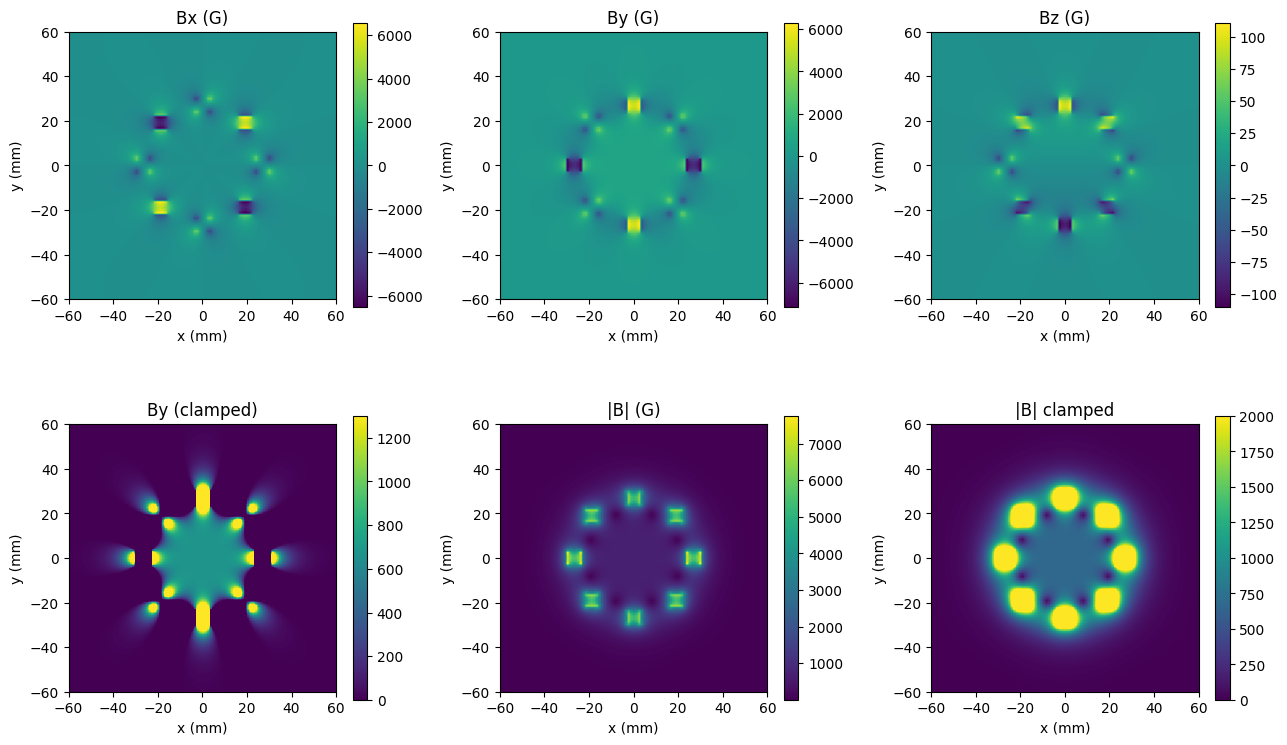

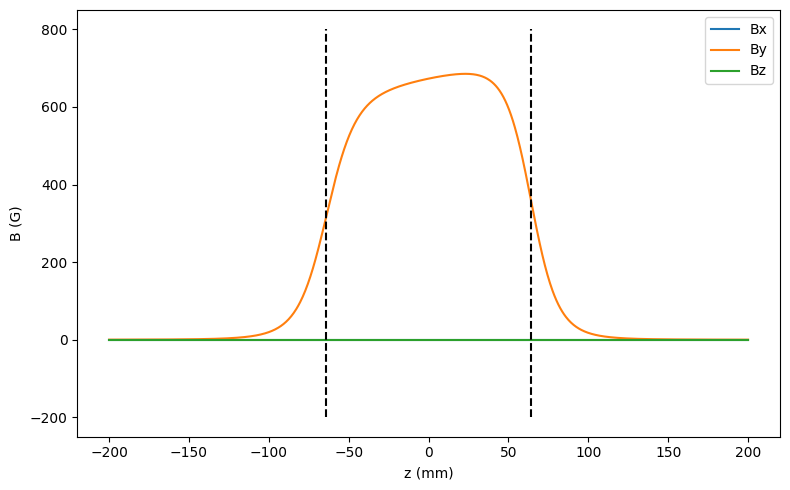

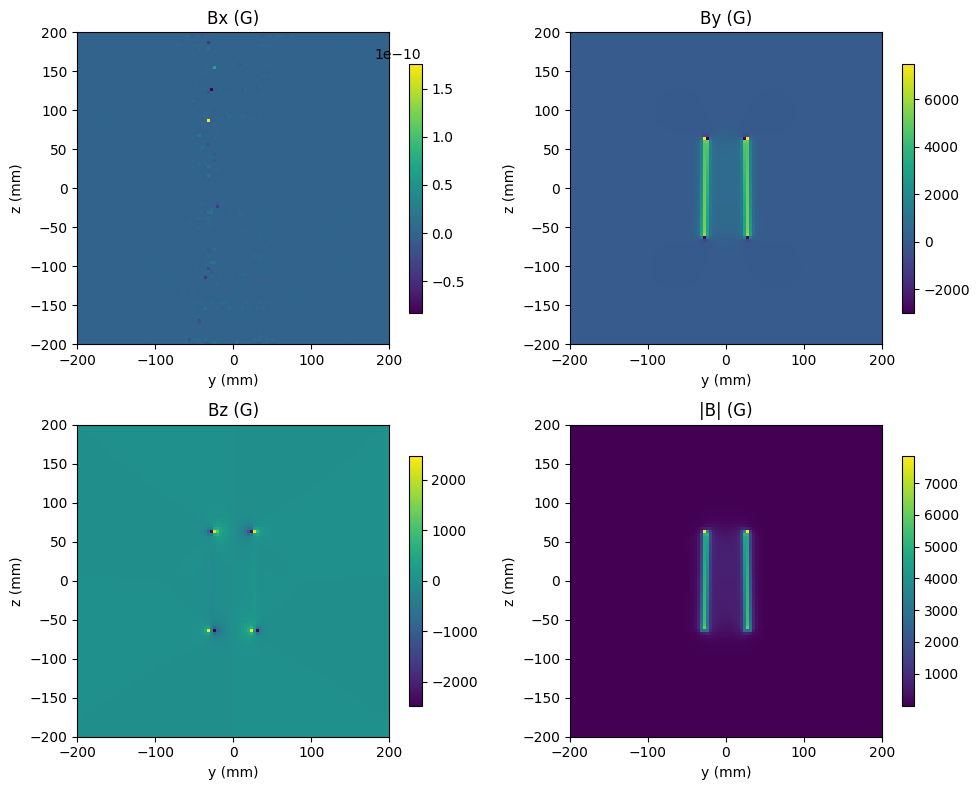

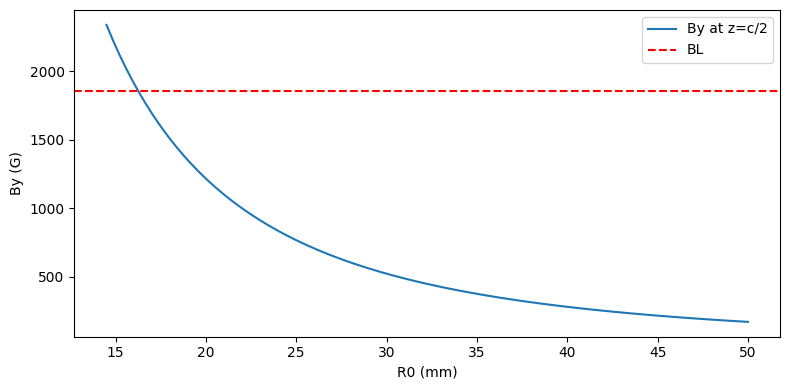

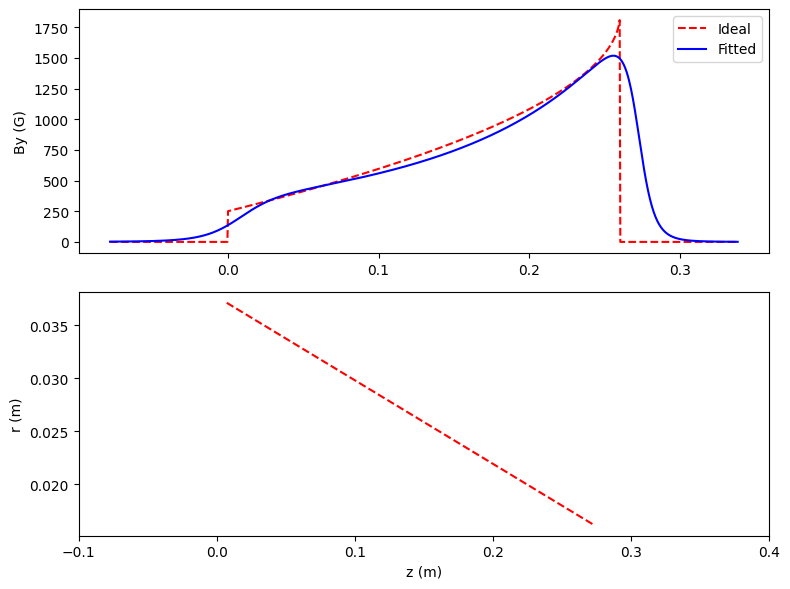

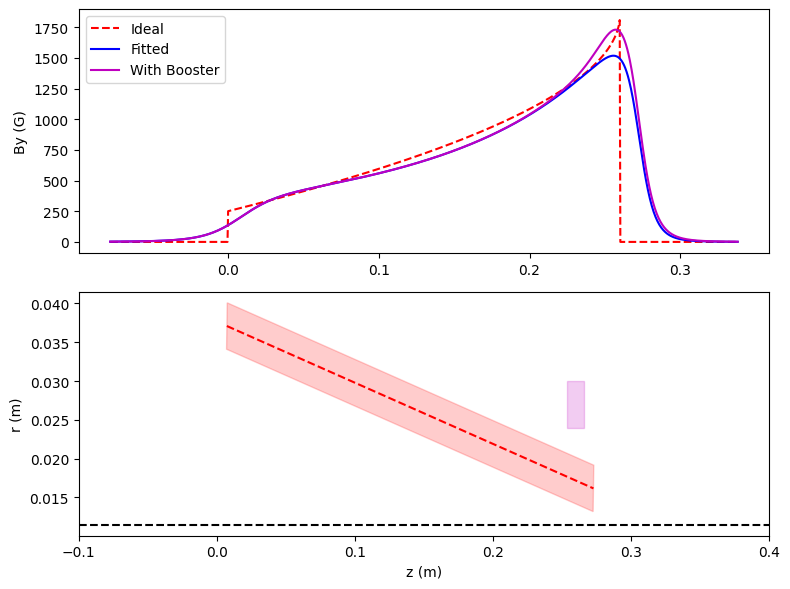

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares


# Angles for the 8 segments of the Halbach array
BETAS = np.linspace(0, 2 * np.pi, 8, endpoint=False)  # n * pi/4 for n=0..7
EPS = 1e-12  # Small value to prevent division by zero


def _broadcast(*arrays):
    '''Broadcast input arrays to a common shape with float dtype.'''
    return np.broadcast_arrays(*[np.asarray(arr, dtype=float) for arr in arrays])


def brond(x, y, z):
    '''Calculate the magnetic field components from a rectangular magnet at position (x, y, z).'''
    x, y, z = _broadcast(x, y, z)   # Ensure inputs are numpy arrays with float dtype
    r = np.sqrt(x**2 + y**2 + z**2) + EPS  # Norm with EPS to avoid division by zero
    r_minus_z = np.clip(r - z, EPS, None)
    r_plus_z = np.clip(r + z, EPS, None)
    r_minus_x = np.clip(r - x, EPS, None)
    r_plus_x = np.clip(r + x, EPS, None)
    frac = np.divide(y * r, x * z + EPS)
    # Compute field components
    bxx = 0.5 * np.log(r_minus_z / r_plus_z)
    byy = -np.arctan(frac)
    bzz = 0.5 * np.log(r_minus_x / r_plus_x)
    return np.stack((bxx, byy, bzz), axis=-1)


def bmagnet(x, y, z, a, b, c, Br):
    '''Calculate the magnetic field from a rectangular magnet
    with dimensions (2a, 2b, 2c) and remanent field Br at position (x, y, z).'''
    term = (
        brond(x - a, y - b, z - c) - brond(x + a, y - b, z - c)
        + brond(x + a, y + b, z - c) - brond(x - a, y + b, z - c)
        + brond(x - a, y + b, z + c) - brond(x - a, y - b, z + c)
        + brond(x + a, y - b, z + c) - brond(x + a, y + b, z + c)
    )
    return (Br / (4 * np.pi)) * term


def bdisrot(x, y, z, a, b, c, Br, r0, z0, alpha, beta):
    '''Calculate the magnetic field from a rotated and displaced rectangular magnet.'''
    x, y, z, r0, z0, alpha = _broadcast(x, y, z, r0, z0, alpha)
    # Coordinate transformation from lab to magnet frame
    # Translation
    xp = x - r0 * np.sin(beta)
    yp = y - r0 * np.cos(beta)
    zp = z - z0
    # Rotation by 2*beta in the xy-plane around z-axis
    xs = np.cos(2 * beta) * xp - np.sin(2 * beta) * yp
    ys = np.sin(2 * beta) * xp + np.cos(2 * beta) * yp
    zs = zp
    # Rotation by alpha around v=cos(beta)*x + sin(beta)*y
    cb = np.cos(beta)
    sb = np.sin(beta)
    ca = np.cos(alpha)
    sa = np.sin(alpha)
    xt = (cb**2 * (1 - ca) + ca) * xs + cb * sb * (1 - ca) * ys + sb * sa * zs
    yt = cb * sb * (1 - ca) * xs + (sb**2 * (1 - ca) + ca) * ys - cb * sa * zs
    zt = -sb * sa * xs + cb * sa * ys + ca * zs
    # Magnetic field in magnet frame
    bvec = bmagnet(xt, yt, zt, a, b, c, Br)
    bxt = bvec[..., 0]
    byt = bvec[..., 1]
    bzt = bvec[..., 2]
    # Rotate back to lab frame
    bxs = (cb**2 * (1 - ca) + ca) * bxt + cb * sb * (1 - ca) * byt - sb * sa * bzt
    bys = cb * sb * (1 - ca) * bxt + (sb**2 * (1 - ca) + ca) * byt + cb * sa * bzt
    bzs = sb * sa * bxt - cb * sa * byt + ca * bzt
    # Rotate back by 2*beta in the xy-plane around z-axis
    bx = np.cos(2 * beta) * bxs + np.sin(2 * beta) * bys
    by = -np.sin(2 * beta) * bxs + np.cos(2 * beta) * bys
    bz = bzs
    return np.stack((bx, by, bz), axis=-1)


def bhallbach8(x, y, z, a, b, c, Br, R0, z0, alpha):
    '''Calculate the magnetic field from an 8-segment Halbach array.'''
    total = None
    for beta in BETAS:
        btmp = bdisrot(x, y, z, a, b, c, Br, R0, z0, alpha, beta)
        if total is None:
            total = np.zeros_like(btmp)
        total += btmp
    return total


def by_component(x, y, z, a, b, c, Br, R0, z0, alpha):
    '''Calculate the By component of the magnetic field from an 8-segment Halbach array.'''
    return bhallbach8(x, y, z, a, b, c, Br, R0, z0, alpha)[..., 1]


def bid_profile(z, length, B0, BL):
    '''Ideal B-field profile for a Zeeman slower.'''
    z = np.asarray(z, dtype=float)
    inside = np.clip(1 - z / length, 0.0, None)
    mask = (z >= 0) & (z <= length)
    return (BL + (B0 - BL) * np.sqrt(inside)) * mask


def main():
    # Define Halbach array parameters
    # Dimensions in mm
    a_mm = 6.0 / 2.0
    b_mm = 6.0 / 2.0
    c_mm = 128.0 / 2.0
    Br = 1.08e4         # Remanent field in Gauss
    R0 = 54.0 / 2.0     # Radius of magnets in mm
    z0 = 0.0            # z-displacement in mm
    alpha = -0.97 * np.pi / 180.0   # Tilt angle in radians

    xgrid = np.linspace(-60.0, 60.0, 101)
    ygrid = np.linspace(-60.0, 60.0, 101)
    X, Y = np.meshgrid(xgrid, ygrid, indexing="xy")
    Bvec_xy = bhallbach8(X, Y, 0.0, a_mm, b_mm, c_mm, Br, R0, z0, alpha)
    Bmag_xy = np.linalg.norm(Bvec_xy, axis=-1)

    # Plotting
    # B-field components in the xy-plane at z=0
    fig1, axes1 = plt.subplots(2, 3, figsize=(13, 8))
    plot_specs = [
        ("Bx (G)", Bvec_xy[..., 0], None),
        ("By (G)", Bvec_xy[..., 1], None),
        ("Bz (G)", Bvec_xy[..., 2], None),
        ("By (clamped)", Bvec_xy[..., 1], (0, 1300)),
        ("|B| (G)", Bmag_xy, None),
        ("|B| clamped", Bmag_xy, (0, 2000)),
    ]
    axes_flat = axes1.flatten()
    for ax, (title, data, clim) in zip(axes_flat, plot_specs):
        im = ax.imshow(
            data,
            origin="lower",
            extent=(xgrid[0], xgrid[-1], ygrid[0], ygrid[-1]),
            cmap="viridis",
        )
        if clim:
            im.set_clim(*clim)
        ax.set_title(title)
        ax.set_xlabel("x (mm)")
        ax.set_ylabel("y (mm)")
        fig1.colorbar(im, ax=ax, shrink=0.8)
    fig1.tight_layout()

    zline = np.linspace(-200.0, 200.0, 1001)
    Bvec_line = bhallbach8(0.0, 0.0, zline, a_mm, b_mm, c_mm, Br, R0, z0, alpha)
    plt.figure(figsize=(8, 5))
    plt.plot(zline, Bvec_line[..., 0], label="Bx")
    plt.plot(zline, Bvec_line[..., 1], label="By")
    plt.plot(zline, Bvec_line[..., 2], label="Bz")
    plt.vlines([-c_mm, c_mm], ymin=-200, ymax=800, colors="k", linestyles="--")
    plt.xlabel("z (mm)")
    plt.ylabel("B (G)")
    plt.legend()
    plt.tight_layout()

    yspan = np.linspace(-200.0, 200.0, 101)
    zspan = np.linspace(-200.0, 200.0, 101)
    Yspan = yspan[np.newaxis, :]
    Zspan = zspan[:, np.newaxis]
    Bvec_yz = bhallbach8(0.0, Yspan, Zspan, a_mm, b_mm, c_mm, Br, R0, z0, alpha)
    fig3, axes3 = plt.subplots(2, 2, figsize=(10, 8))
    for idx, title in enumerate(["Bx", "By", "Bz", "|B|"]):
        data = (
            Bvec_yz[..., idx]
            if idx < 3
            else np.linalg.norm(Bvec_yz, axis=-1)
        )
        ax = axes3.flat[idx]
        im = ax.imshow(
            data,
            origin="lower",
            extent=(yspan[0], yspan[-1], zspan[0], zspan[-1]),
            cmap="viridis",
        )
        ax.set_title(f"{title} (G)")
        ax.set_xlabel("y (mm)")
        ax.set_ylabel("z (mm)")
        fig3.colorbar(im, ax=ax, shrink=0.8)
    fig3.tight_layout()

    gamma = 1 / 4.6e-9
    kL = 2 * np.pi / 423e-9
    M = 40 * 1.66e-27
    h = 6.626e-34
    hbar = h / (2 * np.pi)
    muB = h * 1.4e6
    gJp = 1.0
    vL = 50.0
    v0 = 1000.0

    delta_B = hbar * kL * (v0 - vL) / (gJp * muB)
    B0 = 250.0
    BL = B0 + delta_B
    eta = 0.75
    L = M * v0**2 / (hbar * kL * gamma * eta)
    delta_L = -kL * (v0 + vL) / 2 - gJp * muB / hbar * (BL + B0) / 2

    print(f"Velocity from {v0:.0f} to {vL:.0f} m/s")
    print(f"B-field from {B0:.1f} to {BL:.1f} G")
    print(f"Detuning {delta_L / (2 * np.pi * 1e9):.3f} GHz")
    print(f"Length {L * 100:.1f} cm (eta={eta})")

    R0s = np.linspace(19.0 / 2 + 2 + a_mm, 50.0, 101)
    Bmid = by_component(0.0, 0.0, c_mm / 2, a_mm, b_mm, c_mm, Br, R0s, 0.0, 0.0)
    plt.figure(figsize=(8, 4))
    plt.plot(R0s, Bmid, label="By at z=c/2")
    plt.axhline(BL, color="r", linestyle="--", label="BL")
    plt.xlabel("R0 (mm)")
    plt.ylabel("By (G)")
    plt.legend()
    plt.tight_layout()

    zgrid = L * np.linspace(-0.3, 1.3, 1001)
    a_si = 6e-3 / 2.0
    b_si = 6e-3 / 2.0
    c_si = 128e-3 / 2.0

    def residuals(p):
        return bid_profile(zgrid, 1.05 * L, B0, BL) - by_component(
            0.0, 0.0, zgrid, a_si, b_si, p[0], Br, p[1], p[2], p[3]
        )

    par0 = np.array([L / 2.0, 0.028, L / 2.0, -5 * np.pi / 180.0])
    parfit = least_squares(residuals, par0).x

    plt.figure(figsize=(8, 6))
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(zgrid, bid_profile(zgrid, L, B0, BL), "r--", label="Ideal")
    ax1.plot(
        zgrid,
        by_component(0.0, 0.0, zgrid, a_si, b_si, parfit[0], Br, parfit[1], parfit[2], parfit[3]),
        "b-",
        label="Fitted",
    )
    ax1.set_ylabel("By (G)")
    ax1.legend()
    ax2 = plt.subplot(2, 1, 2)
    ax2.plot(
        parfit[2] + parfit[0] * np.array([-1, 1]),
        parfit[1] + np.sin(parfit[3]) * parfit[0] * np.array([-1, 1]),
        "r--",
    )
    ax2.set_xlim(-0.1, 0.4)
    ax2.set_xlabel("z (m)")
    ax2.set_ylabel("r (m)")
    plt.tight_layout()

    R2 = 27e-3
    c2 = 6e-3
    z2 = L
    alpha2 = -5 * np.pi / 180.0

    plt.figure(figsize=(8, 6))
    ax1 = plt.subplot(2, 1, 1)
    base_by = by_component(0.0, 0.0, zgrid, a_si, b_si, parfit[0], Br, parfit[1], parfit[2], parfit[3])
    aux_by = by_component(0.0, 0.0, zgrid, a_si, b_si, c2, Br, R2, z2, alpha2)
    ax1.plot(zgrid, bid_profile(zgrid, L, B0, BL), "r--", label="Ideal")
    ax1.plot(zgrid, base_by, "b-", label="Fitted")
    ax1.plot(zgrid, base_by + aux_by, "m-", label="With Booster")
    ax1.legend()
    ax1.set_ylabel("By (G)")
    ax2 = plt.subplot(2, 1, 2)
    ax2.plot([-0.1, 0.4], 1e-3 * (19 / 2 + 2) * np.ones(2), "k--")
    ax2.plot(
        parfit[2] + parfit[0] * np.array([-1, 1]),
        parfit[1] + np.sin(parfit[3]) * parfit[0] * np.array([-1, 1]),
        "r--",
    )
    core_x = parfit[2] + parfit[0] * np.array([-1, 1, 1, -1]) + a_si * np.sin(parfit[3]) * np.array([1, 1, -1, -1])
    core_y = parfit[1] + np.sin(parfit[3]) * parfit[0] * np.array([-1, 1, 1, -1]) + a_si * np.cos(parfit[3]) * np.array([-1, -1, 1, 1])
    ax2.fill(core_x, core_y, color="r", alpha=0.2)
    booster_x = z2 + c2 * np.array([-1, 1, 1, -1])
    booster_y = R2 + a_si * np.array([-1, -1, 1, 1])
    ax2.fill(booster_x, booster_y, color="m", alpha=0.2)
    ax2.set_xlim(-0.1, 0.4)
    ax2.set_xlabel("z (m)")
    ax2.set_ylabel("r (m)")
    plt.tight_layout()


if __name__ == "__main__":
    main()